<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Introduction to Deep Learning

## 08. Recurrent Networks

---

## [Recurrent Neural Networks (RNN)](https://keras.io/api/layers/recurrent_layers/)

<img src="./pics/external/lstm/recurrent_neural_network_unfold.svg" alt="Recurrent neural network unfold.svg" height="213" width="640"><br>By <a href="//commons.wikimedia.org/wiki/User:Ixnay" title="User:Ixnay">François Deloche</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=60109157">Link</a></p>

### Purpose

The networks we talked about so far had quite simple architectures, we could express them as a series of matrix multiplications. Lots of the cases they are capable of perfectly express wide range of problems. However some of the real life problems requires information from the previous events - solving a problem requires some sort of "memory". Recurrent Neural Networks solve this problem by storing the previous inputs in their inter state. This memory enables to recognize text, speech, handwriting, etc.

So basically the neuron has memory and remembers it's previous informations by using the results of the previous inputs. This behaviour can be interpreted as the neuron with one extra input: it's previous output. For easier implementation (both matematical, bot programmatical viewpoint) we unfold this neuron into a chain of multiple neurons as you can see on the image above.

#### Use cases

- Sequence prediction: $[1, 2, 3, 4, 5] \rightarrow \fbox{RNN} \rightarrow [6]$
    - Weather Forecasting
    - Stock Market Prediction
- Sequence classification: $[1, 2, 3, 4, 5] \rightarrow \fbox{RNN} \rightarrow [\text{"good"}]$
    - Anomaly Detection
    - Sentiment Analysis
- Sequence to sequence prediction: $[1, 2, 3, 4, 5] \rightarrow \fbox{RNN} \rightarrow [6, 7, 8, 9, 10]$
    - Language Translation

### How do they work?

Unrolling (or unfolding) means that we spread a neuron into a network of neurons for a complete sequence. Sequence length is one important parameter for the model. Each step in a sequence has its own dedicated neuron.

The formal description of the prediction is as follows:

$t$ is the step we are observing at a time, $x_t$ is the input at a given step $t$. $x_t$ can be the opening price of a stock at a given date. $h_t$ is the hidden state, or the memory of the neuron. It is computed using the previous memory value and the actual input using the $h_t=f(Ux_t + Vh_{t-1})$ equation, where $f$ is the activation function, and $o_t = f(Wh_t)$. The initial memory (denoted as $h_{-1}$) is usually set to zero. There are 3 set of weights in each neuron: $U$ is the input weight, $V$ is the weight for the hidden state, and finally $W$ is the output weight.

$h_t$ acts as a memory storing the information from the previous time steps, and the output $o_t$ relies only on the actual memory value. $U$, $V$ and $W$ is shared among the unrolled neurons, reducing the amount of parameters required for training. The output of a recurrent neuron can be either a single value, or the whole sequence as well.

### Training

A modified version of the Backpropagation algorithm called **B**ack**p**ropagation **T**rough **T**ime (BPTT) is used to calculate the update rules for the weights. Do not let the fancy name confuse you, it's the same algorithm we used, the trick is that we have to backpropagate $t$ steps in the network. Luckily the chain rule is applicable to compute the gradients and the update values are computable recursivably.
Formally:

Using the forward equations:
$$\begin{align}
    a_t & = Ux_t + Vh_{t-1} \\
    h_t & = f(a_t) \\
    o_t & = f(Wh_t)
\end{align}$$

The delta at the "output layer" of the unrolled neuron:
$$\begin{align}
    \delta^t_o = (\hat{o_t} - o_t) \otimes h_t 
\end{align}$$


The delta at the "hidden layer" of the unrolled neuron:
$$\begin{align}
    \delta^t_h = f'(a_t)(U\delta^t_o + W\delta^{t+1}_h)
\end{align}$$

### Types of RNNs
- One to one: Vanilla recurrent neural network, one input value, one output value. 
- One to many: one input with multiple outputs (a sequence of outputs)
- Many to one: multiple input (a sequence) and one output value
- Many to many: multiple inputs and multiple outputs

### In Practice

#### Many to One predictor: Build a simple decay predictor

The contents of the computer RAM have to be refreshed constantly to keep its stored values. The current in the memory curcuits decays constantly. We have a series of observations about the refreshes and an observed voltage at the end of the observation window. Our goal is to predict the current at the end of our observation. 

The length of our observation is 10 μs and its resolution is 1 μs. Each refreshment set the voltage to 1.5V and its value is decreasing by 0.2V each μs.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

Using TensorFlow backend.


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

##### Data generation

Let's generate 256 samples by randomly selecting the refresh signals timestep. 

In [3]:
sample_size = 256
length = 10
features = 1

row_index = np.arange(sample_size)
col_index = np.random.randint(length, size=sample_size)

X = np.zeros((sample_size, length, features))
X[(row_index, col_index)] = 1

y = np.maximum(1.5 - (length - col_index - 1) * 0.2, 0)

In [4]:
# 256 sample, 10 time steps, and 1 feature
X.shape

(256, 10, 1)

In [5]:
X[0, :, 0], y[0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 0.8999999999999999)

##### Build the model:

Let's have a really simple network with:
- 25 RNN unit with linear activation
- 1 fully connected output layer with ReLU activation
- adam optimizer with default parameters
- since we want to predict a continous value, we use mse loss
- RMSE evaluation metric


The hardest part is the setup of the RNN layer:
- We have to set the correct input shape: 
    - we have 256 samples
    - the sequences are 10 μs long
    - have one feature
- We ignore the sample size, and use the last two dimensions.

In [6]:
model = Sequential()

model.add(SimpleRNN(25, input_shape=(length, features)))
model.add(Dense(1))
model.add(Activation('relu'))

model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 25)                675       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


Fit and test our model

In [7]:
model.fit(X, y, epochs=50, batch_size=64, verbose=0)

In [8]:
X_test = np.identity(length).reshape((length, length, 1))
model.predict(X_test)

array([[0.        ],
       [0.        ],
       [0.09830745],
       [0.2983121 ],
       [0.49875176],
       [0.7021555 ],
       [0.90184677],
       [1.1016666 ],
       [1.2985066 ],
       [1.492656  ]], dtype=float32)

#### Many to Many: Build a simple decay predictor v2

Instead of predicting the voltage at the end of the observation window, let's predict the voltage every μs.

##### Data generation

We'll reuse the same input from the previous example and only change the expected output. Instead of generating one expected output value, we generate a sequence of volts. For simplicity we use a 10 μs output window.

In [9]:
prototype = np.array([1.5, 1.3, 1.1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.0, 0.0])
y_series = np.vstack([
    np.concatenate((np.zeros(col_index[i]), 
                    prototype[:(length - col_index[i])]))
    for i in range(sample_size)
]).reshape(sample_size, length, features)

We use the same network layout, however we have to modify the RNN layer by setting the `return_sequences` parameter to `True` which will make the neurons to output the values at each step instead of outputting only the final value.

In [10]:
model = Sequential()

model.add(SimpleRNN(25, 
                    input_shape=(length, features), 
                    return_sequences=True))
model.add(Dense(1))
model.add(Activation('relu'))

model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 25)            675       
_________________________________________________________________
dense_2 (Dense)              (None, 10, 1)             26        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 1)             0         
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


We already dealt with the output shape during the data generation by transforming the vectors into 3d tensors with `sample size` x `sequence length` x `features` dimensions.

In [11]:
model.fit(X, y_series, epochs=100, batch_size=64, verbose=0)

In [12]:
model.predict(X_test)

array([[[1.4878188e+00],
        [1.3058318e+00],
        [1.1178910e+00],
        [8.8020480e-01],
        [7.0924944e-01],
        [5.1142454e-01],
        [3.0281731e-01],
        [1.0091905e-01],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[6.7333039e-03],
        [1.4746851e+00],
        [1.3155645e+00],
        [1.1179742e+00],
        [8.9129460e-01],
        [7.0244670e-01],
        [5.0533491e-01],
        [2.9662108e-01],
        [1.0232738e-01],
        [0.0000000e+00]],

       [[6.7333039e-03],
        [0.0000000e+00],
        [1.4885476e+00],
        [1.3125480e+00],
        [1.1068661e+00],
        [8.9462495e-01],
        [7.0652765e-01],
        [4.9769548e-01],
        [3.0339536e-01],
        [9.8332867e-02]],

       [[6.7333039e-03],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.4892190e+00],
        [1.3025771e+00],
        [1.0963732e+00],
        [9.0400553e-01],
        [6.9676661e-01],
        [4.9596560e-01],
        [2.9757127e

### Exercise

Forecast monthly closing stock values.
We generate a timeseries consisting one stock closing price over 220 months, starting from 2001.  
Our task is to create a model which is able to predict the closing value of the next month. The input is 20 months of stock prices and we want our model to predict a series of 20 prices starting from the second month instead of predicting just one.  

Eg.:

input months:  `[2001.01, 2001.02, ..., 2002.07 , 2002.08]`  
output months: `[2001.02, 2001.03, ..., 2002.08 , 2002.09]`  

So we basically ask our model to repeat the values seen in the beginning of the input, and guess one value after.

In [13]:
def generate_stock_prices(start='2001', length=201, freq='M'):
    index = pd.date_range(start=start, periods=length, freq=freq)
    values = np.random.uniform(-18, 18, size=length).cumsum()
    values += np.abs(values.min()) + 1e-1 # stock prices never go below 0
    return pd.Series(values, index)

In [14]:
ts = generate_stock_prices(start='2001', length=222)
stock_prices = ts.values

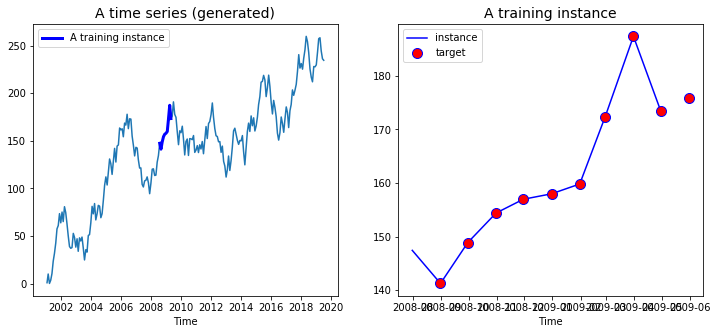

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.plot(ts.index, ts)
ax1.plot(ts.index[90:100], ts[90:100], "b-", linewidth=3, label="A training instance")
ax1.legend(loc="upper left")
ax1.set_xlabel("Time")
ax1.set_title("A time series (generated)", fontsize=14)

ax2.plot(ts.index[90:100], ts[90:100], "b-", markersize=8, label="instance")
ax2.plot(ts.index[91:101], ts[91:101], "bo", markersize=10, label="target", markerfacecolor='red')
ax2.set_title("A training instance", fontsize=14)
ax2.set_xlabel("Time")
ax2.legend(loc="upper left")

#### Generate samples

20 month long samples, the expected output is shifted by one month.

In [24]:
def create_stock_samples(series, length, input_features, output_features):
    # useful trick: reshape is able to deduct the last shape if it is set to -1
    X = series[:-output_features].reshape(-1, length, input_features)
    y = series[output_features:].reshape(-1, length, output_features)
    return X, y

In [21]:
length = 20
input_features =  1
output_features = 1
train_size = 201

In [22]:
stock_train = stock_prices[:train_size]
stock_test = stock_prices[train_size:]

stock_train.shape, stock_test.shape

((201,), (21,))

In [25]:
X_train, y_train = create_stock_samples(stock_train, length, input_features, output_features)
X_test, y_test = create_stock_samples(stock_test, length, input_features, output_features)

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10, 20, 1), (10, 20, 1), (1, 20, 1), (1, 20, 1))

#### Build the model

Expected architecture:
- RNN layer consisting 120 neurons with ReLU activation
- [optional]: Dense layer with 60 neurons and ReLU activation
- Dense output with linear activation

Use `Adam` optimzer.

Questions to answer:
- What is the input shape?
- What is the output shape?
- How should you setup your recurrent layer for this problem?
- What is the ML task?
- Which cost function is appropriate here?

In [30]:
# 1. Build the model
stock_model = Sequential()

stock_model.add(SimpleRNN(120, input_shape=(length, input_features), return_sequences=True, activation='relu'))
stock_model.add(Dense(60, activation='relu'))
stock_model.add(Dense(1, activation='linear'))

# 2. Compile the model
stock_model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

stock_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 20, 120)           14640     
_________________________________________________________________
dense_5 (Dense)              (None, 20, 60)            7260      
_________________________________________________________________
dense_6 (Dense)              (None, 20, 1)             61        
Total params: 21,961
Trainable params: 21,961
Non-trainable params: 0
_________________________________________________________________


#### Fit the model

It is a pretty complex problem so use 5000 epochs, but use early stopping with 25 patience value. Use the test data as validation.

Extra: 
tqdm has a nice progress bar you can use:
- import `TqdmCallback` from `tqdm.keras` and add it to the callbacks
- set verbosity to 0.

In [35]:
# 3. Fit the model
from tqdm.keras import TqdmCallback

stock_model.fit(
    X_train, y_train, 
    epochs=5000, 
    verbose=0, 
    callbacks=[EarlyStopping(patience=25), TqdmCallback()]
)

C:\Users\szige\Anaconda3\envs\ceu_dl\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,root_mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


#### Validation

Let's observe how our model perform on the test data.

In [36]:
y_pred = stock_model.predict(X_test)

Text(0.5, 0, 'Time')

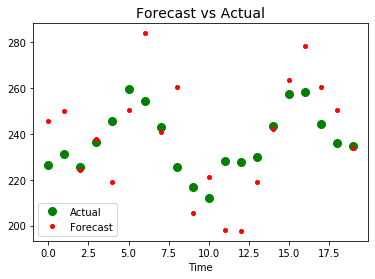

In [37]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

---

## [Long-Short Term Memory (LSTM) Networks](https://keras.io/api/layers/recurrent_layers/lstm/)

### Purpose

The biggest problem with the simple RNN setup is easily understood, if we consider a model which has to deal with the following sentence: "I grew up in _France_... that's why I speak fluent _French_." The related information are far away from each other and it's easy for the network to miss these nuances and however in theory they can learn them, but in practice they often unable to do so.  
But a more complex version of them is able to overcome this difficulty, they're called LSTMs.

They are build to have long term memory, and have the same kind of chained structure, but the modules themselves are different. What they are excel at is learning complex series with the ability to find sequence boundaries.



### How do they work?

<img src="./pics/external/lstm/LSTM3-chain.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

LSTMs also have the same chain like structure as the Vanilla RNNS, but their hidden state is a complex one. Instead of having a simple hidden state, it contains multiple gates to control the remembering and forgetting process.

<img src="./pics/external/lstm/LSTM3-C-line.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

The hidden state (also referred as cell state) of the LSTM neuron is the pipe on the top which is controlled by the different gates inside the neuron. These gates uses sigmoid functions to control the amount of signal going through the cell. If you recall that sigmoid function outputs values between 0 and 1, you can see that the gates are working as taps, controlling the amount of signal going through the pipe. There are 3 gates in an LSTM neuron.

##### Forget gate

<img src="./pics/external/lstm/LSTM3-focus-f.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

The first interaction with the cell state "pipe" is to determine how much of the previous signal we want to filter out, or in other words: forget, hence the name *forget gate*. This gate uses a sigmoid activation function to control the amount of signal to keep. Using the previous output $h_{t-1}$ and the actual input $x_t$ to determine the $f_t$ multiplier for the previous state $C_{t-1}$.  

##### Input gate

<img src="./pics/external/lstm/LSTM3-focus-i.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

After forgetting the unwanted values the cell will determine what it wants to store based on the actual input and the previous output. That is the job of the *input gate*, consisting two parts: a tanh layer to generate $\tilde{C}_t$, the values to store  and a sigmoid layer which determines $i_t$ the amount of the information the cell should store. 

<img src="./pics/external/lstm/LSTM3-focus-C.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

Using the forget and input gates we modify the $C_{t-1}$ previous state by first multiplying by $f_t$ and then add the new information $i_t * \tilde{C}_t$.

##### Output gate

<img src="./pics/external/lstm/LSTM3-focus-o.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

The final step is to merge the updated cell state $C_t$ with the actual and previous inputs $h_{t-1}$ and $x_t$. We handle the two input sources (state, and input) separately: 
1. the *inputs* are multiplied and used as inputs in an ordinary neuron with sigmoind activation function, and 
2. the *cell state* is going through a tanh activation gate,
3. finally the two sources are multiplied to generate $t_t$, the *output* of the neuron.
This output is used as the output of the neuron, but also passed forward to the neuron in the next timestep.

##### Example

Using the NLP example from before: The LSTM starts reading the input sentence and using the input gate, store the subject of the sentence, but once it reaches the end of a sentence by reading a `"."` character, the LSTM wants to forget about the subject using the *forget gate*, and select the next one using the *input gate*, again. In this particular case, the neuron wants to to output information about the subject, specifically that the speaker is French, so it's *output gate* will both passes the information forward to later learn about the language skills of said subject and also outputs the nationality of the speaker.

#### Modification: GRU

<img src="./pics/external/lstm/LSTM3-var-GRU.png" width="600"><br>By <a href="https://colah.github.io/about.html">Christopher Olah</a>, <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Link</a>

There are many different version of the described model, but one of the most popular modification is the **G**ated **R**ecurrent **U**nit or *GRU* ([paper](http://arxiv.org/pdf/1406.1078v3.pdf) by Cho, et al., 2014) which merges the cell state with the hidden state and the input gate with the forget gate creating a single *update gate*. Since it encorporates fewer gates it uses less parameters so it is becoming simpler.

#### Training

Training an LSTM is really similar training the Vanilla RNNs using the same unfolding view of the neuron but LSTMs have much more parameters to set in each iteration, so it is more affected by the vanishing and exploding gradient problem. We can use the chain rules and the recursive calculation of the deltas as well, however we omit the actual equations this time. The curious reader can find the calculation details in the original [paper](http://www.bioinf.jku.at/publications/older/2604.pdf) by Hochreiter & Schmidhuber (1997).

### In Practice

#### 1. Learning the alphabet

Let's build a network to learn to continue the alphabet, but the length of the given sequence is variable.

In [38]:
from keras.layers import LSTM
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences

from livelossplot import PlotLossesKeras

In [39]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# create mapping of characters to indexes
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}

In [40]:
sample_size = 1000
length = 5
features = 1
output_size = len(alphabet)

In [41]:
def generate_alphabet_samples(max_length, output):
    length = np.random.randint(2, max_length + 1)
    start = np.random.randint(0, len(alphabet) - length - 1)
    sequence = list(range(start, start + length + 1))
    return sequence[:-1], sequence[-1]

In [44]:
X_raw, y_raw = zip(*[generate_alphabet_samples(length, output_size) 
                     for _ in range(sample_size)])

In [45]:
X = pad_sequences(X_raw, maxlen=length, dtype='float32')
# reshape X to [samples x time steps x features] shape
X = np.reshape(X, (-1, length, features))
# normalize
X = X / output_size

# convert y to array
y = np.array(y_raw)

In [46]:
model = Sequential()
model.add(LSTM(32, input_shape=(length, features)))
model.add(Dense(output_size))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

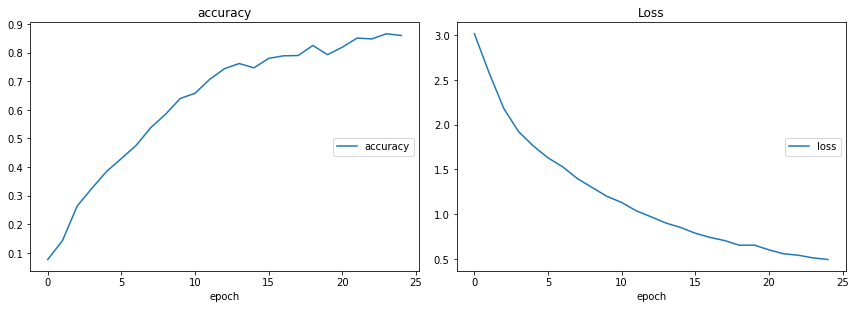

accuracy
	accuracy         	 (min:    0.077, max:    0.866, cur:    0.860)
Loss
	loss             	 (min:    0.493, max:    3.014, cur:    0.493)


In [47]:
batch_size = 1
model.fit(X, y, 
          epochs=25, 
          batch_size=batch_size, 
          verbose=0, 
          callbacks=[PlotLossesKeras()])

In [48]:
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 80.90%


In [49]:
for i in range(20):
    pattern_index = np.random.randint(sample_size)
    x = X[pattern_index].reshape(-1, length, features)
    prediction = np.argmax(model.predict(x, verbose=0))
    
    pattern = [int_to_char[value] for value in X_raw[pattern_index]]
    result = int_to_char[prediction]
    
    print(pattern, "->", result)

['G', 'H', 'I', 'J', 'K'] -> L
['G', 'H', 'I', 'J'] -> K
['A', 'B', 'C'] -> D
['P', 'Q', 'R'] -> S
['K', 'L', 'M', 'N'] -> O
['M', 'N', 'O', 'P'] -> Q
['A', 'B', 'C', 'D', 'E'] -> F
['H', 'I', 'J', 'K'] -> L
['C', 'D'] -> E
['M', 'N', 'O'] -> P
['O', 'P', 'Q', 'R'] -> T
['A', 'B'] -> C
['K', 'L', 'M', 'N'] -> O
['S', 'T', 'U', 'V', 'W'] -> Y
['A', 'B', 'C', 'D', 'E'] -> F
['C', 'D', 'E', 'F', 'G'] -> H
['V', 'W'] -> Y
['T', 'U'] -> U
['L', 'M', 'N'] -> O
['F', 'G', 'H', 'I'] -> J


#### 2. Build a sentiment predictor on movie reviews

Build a sentiment prediction on the built-in movie reviews dataset. Sentiment value is a numerical representation of a written text. 5 means positive, 3 is neutral and 1 is negative opinion. In this particular problem these values are transformed into a binary problem: 1 means positive review, and 0 means negative.   
Let's make use of an embedding layer to learn a textual representation of the reviews, and use them as a sequence of inputs. Our target value is the sentiment value for any given document.

In [50]:
from keras.datasets import imdb
from keras.layers import Embedding

In [51]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

17465344/17464789 [==============================] - 1s 0us/step


In [52]:
max_review_length = 500
# pad sequences will fill every doc in the corpus to a given length
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test = pad_sequences(X_test, maxlen=max_review_length)

In [53]:
embedding_vector_length = 32

model = Sequential([
    Embedding(input_dim=top_words,                 # number of words in the vocab
              output_dim=embedding_vector_length,  # size of the embedding vector
              input_length=max_review_length),     # size of the documents
    LSTM(units=100),
    Dense(1, activation='sigmoid')
])

In [54]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train, y_train, 
          validation_split=0.1, 
          epochs=3, 
          batch_size=64)

C:\Users\szige\Anaconda3\envs\ceu_dl\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 260s 12ms/step - loss: 0.4771 - accuracy: 0.7762 - val_loss: 0.3716 - val_accuracy: 0.8464
Epoch 2/3
 2944/22500 [==>...........................] - ETA: 3:27 - loss: 0.3147 - accuracy: 0.8777

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=16)
print('test loss: {:.2%}, test accuracy: {.2%}'.format(*score))

#### 3. Build a calculator

Let's build a model which is able to calculate the sum of two numbers.  
This is actually a more interesting problem than it seems for the sight: The operation is given as text, just as the expected output. To solve this problem we are going to introduce an LSTM architecture that is usually used in machine translation, **encoder - decoder** pattern.

The encoder-decoder pattern is used to solve sequence to sequence (seq2seq) problems and consists of two LSTM layers, one for encoding the input sequence, and one for to decode the information coming from the encoder into the output. The encoder layer will be responsible to create an inner model about its input while the output interprets this representation and generates its translation.

Let's see it in action, but first we have to generate the data.

In [56]:
chars = "0123456789+ "

def encode(expression, width, mapping):
    string = '+'.join([str(exp) for exp in expression])
    padding = ' ' * (width - len(string))
    string_expression = string + padding
    encoded = np.array([mapping.index(char) for char in string_expression])
    one_hot = np.zeros((width, len(mapping)))
    one_hot[(np.arange(width), encoded)] = 1
    return one_hot

def decode(encoded, mapping):
    _, indices = np.nonzero(encoded)
    string = ''.join(mapping[index] for index in indices)
    numbers = string.strip().split('+')
    decoded = np.array([int(number) for number in numbers])
    return decoded

def generate_calculation_sample(max_value, n_numbers, mapping):
    x_max_width = len(str(max_value)) * n_numbers + n_numbers - 1
    y_max_width = len(str(max_value * n_numbers))
    
    X = np.random.randint(1, max_value + 1, size=n_numbers)
    y = np.sum(X, keepdims=True)
    
    X_encoded = encode(X, width=x_max_width, mapping=mapping)
    y_encoded = encode(y, width=y_max_width, mapping=mapping)
    
    return X_encoded, y_encoded
    
def generate_calculation_samples(samples, max_value, n_numbers, mapping):
    x_max_width = len(str(max_value)) * n_numbers + n_numbers - 1
    y_max_width = len(str(max_value * n_numbers))
    
    X, y = zip(*[generate_calculation_sample(max_value, n_numbers, mapping)
                 for _ in range(samples)])
    
    X = np.array(X).reshape(samples, x_max_width, len(mapping))
    y = np.array(y).reshape(samples, y_max_width, len(mapping))
    
    return X, y

In [57]:
max_value = 99
n_numbers = 2
input_length = len(str(max_value)) * n_numbers + n_numbers - 1
output_length = len(str(max_value * n_numbers))
samples = 5000
features = len(chars)

X, y = generate_calculation_samples(samples, max_value, n_numbers, chars)
X.shape, y.shape

((5000, 5, 12), (5000, 3, 12))

Let's build the model!

Our network will have:

**encoder layer**:

LSTM
- 128 neurons
    - input shape: (`input string length` x `character mapping size`)
    - without return_sequence

**decoder layer**:

Repeater
- 1 special repeat layer which repeats the same vector n times
    - n: `output string length`

LSTM
- 128 neurons
    - input shape is automatically determined
    - with return_sequence
    
**output layer**:

Dense network
- `character mapping size` neurons
- `softmax` activation

In [58]:
from keras.layers import RepeatVector
from keras.utils import plot_model

In [59]:
calculator = Sequential()

# Encoder
calculator.add(LSTM(units=128, input_shape=(input_length, features)))

# Decoder
calculator.add(RepeatVector(n=output_length))
calculator.add(LSTM(units=128, return_sequences=True))

# Output
calculator.add(Dense(features))
calculator.add(Activation(activation='softmax'))

# compile
calculator.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

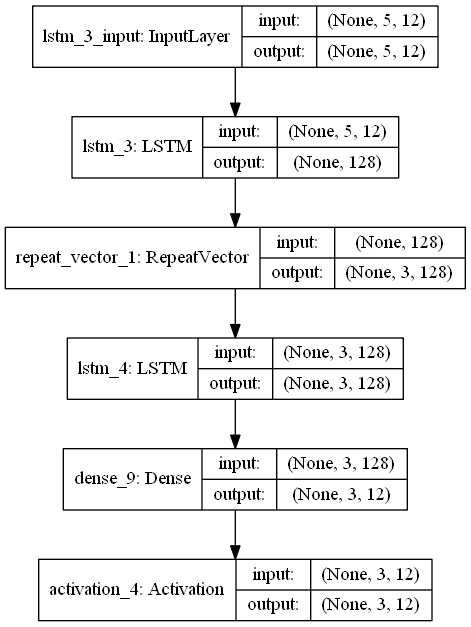

In [60]:
plot_model(calculator, show_shapes=True, show_layer_names=True)

Training the model

In [ ]:
epochs_num = 50
batch_size = 128

calculator.fit(X, y, 
          epochs=epochs_num, 
          batch_size=batch_size, 
          verbose=0, 
          callbacks=[PlotLossesKeras()])

Test the model

In [ ]:
test_samples = 10

examples, expected = generate_calculation_samples(test_samples, max_value, n_numbers, chars)
prediction = calculator.predict(examples.reshape(-1, input_length, features))

for i in range(test_samples):
    input_numbers = decode(examples[i], chars)
    expected_value = decode(expected[i], chars)[0]
    predicted = int(''.join([chars[pred] for pred in np.argmax(prediction[i], axis=1)]))
    print(f"[{'x' * (expected_value == predicted):1}] "
          f"{' + '.join(str(n) for n in input_numbers): <7} "
          f"= {predicted: >3} "
          f"[{expected_value: >3}]")

### Exercise

How would you modify the MNIST example to work with 2 low resolution mnist picture?

### Good job!

In the next chapter we'll discover how can we deal with situations where we don't have prior knowledge about the problem and we have to explore and then exploit the environment using (deep) reinforcement learning in [DL 09 Reinforcement Learning](./DL_09_Reinforcement_Learning.ipynb).